# A Microeconomic Model for Parachains with Native Tokens V2: Clients, Collators and Treasury
### **Author**: Eray Sabancilar
### **Last updated**: 23.03.2020

In this notebook, we analyze a dynamic microeconomic model of a parachain with a native token in order to study its revenues, expenses, token price and wealth distribution given the DOT price and the parachain cost and deposit. We also use inflation & interest rates from our NPoS economics model as inputs. For a detailed description see:


https://hackmd.io/MXjnqF00Sim1p1UfLV6vXw?view

### Parameters

In our simulation, we use the following set of parameter values.

| Parameters                  | Values                               |
| --------                    | --------                             | 
| Era                         | $t=$ 1 day                            |
| Total Time                  | $T=$ 20 years                       |
| Baumol–Tobin Parameter for DOT | $c_{DOT}=$ 1                       |
| DOT Price Normalization     | $N_{DOT/USD}$ = 35                  | 
| Fraction of Total Payouts Financed by Parachains |$f_p=$ 0.6 |
| Number of parachains| $N_\tau$ = 100 |
| Initial Project Valuation (USD) | $V_0$ = \$10 M
| Initial Token Supply | $N_{tkn}$ = 1 M|
| Initial Token Price (USD)| $P_{tkn}$ = \$10|
| Number of Agents | $N_{private} = 10$, $N_{ico}$ = 3000, $N_{founders} = 20$, $N_{ecosystem} = 50$, $N_{rewards} = 1$, $N_{future-fundraising}$ = 1, $N_{treasury}$ = 2, $N_{collators}$ = 200|
| Initial Number of Clients |$N_{initial-clients}$ = 200|
| Initial Token Distribution | Private Investors (10%), ICO (30%), Founders & Employee (20%), Rewards to Collators (10%), Reserved for Ecosystem Funding (15%), Reserved for Future Fundraising (15%)|
| Collator Fee (TKN)| 0.02|
| Service fee in terms of the collator fee |$f_{service}$ = 2|
| Profit share for collators | $f_{profit-collator}$ = 0.5|
| Reward factor for collators | $f_{rewards}$ = 0.1 |
| Douglas-Cobb Utility Parameters | $a$ = 0.8, $b$ = 0.2|
| Bechmark Utility| $U_{benchmark}$ = 10|
| Transaction demand adjustment parameter| $\beta$ = 0.01|
| Annual opportunity cost of capital| $r_{opp}$ = 0.1
| Baumol–Tobin Parameter for TKN | $c_{tkn}$ = 0.1|

### Import Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

### Parameters

In [2]:
# Total time length
year = 20
T = 365*year

# NPoS Parameters
# Baumol–Tobin cost parameter
c_dot = 1
# DOT Price normalization
N_P_dot = 35
# Fraction of NPoS payouts to be covered by the parachain slot payments
f_p = 0.6
# Number of parachains allocated in a given period
N_p = 100

#Token Parameters
# Initial Project Valuation in USD
V0 = 10*10**6
# Initial Token Supply
N_tkn = 1*10**6
#Initial Token Price in USD
P_tkn_0 = V0/N_tkn

# Number of agents
N_private = 10
N_ico = 3000
N_founders = 20
N_ecosystem = 50
N_rewards = 1
N_future_fundraising = 1
N_treasury = 2

# Number of collators (assuming collators are from ico investors)
N_collators = 200

# Number of Clients
# Number of potential clients from ico investors
N_potential_clients = N_ico - N_collators
# Number of clients from ico investors at genesis to be selected randomly
N_clients_0 = 200
# Passive accounts
N_passive_0 = N_potential_clients - N_clients_0

# Initial Token Distribution
# Private Investors:
N_private_tkn = 0.1*N_tkn
# Crowdfunding ICO Participants
N_ico_tkn = 0.3*N_tkn
# Founders & Employee
N_founders_tkn = 0.2*N_tkn
# Ecosystem Funding
N_ecosystem_tkn = 0.1*N_tkn
# Rewards to Collators
N_rewards_tkn = 0.15*N_tkn
# Reserved for Future Fundraising
N_future_fundraising_tkn = 0.15*N_tkn
# Treasury accounts 
N_treasury_tkn = 0
# N_treasury_dot = (N_private_tkn + N_ico_tkn)*P_tkn_0/P_dot_0 to be calculated later

# Revenue, Cost and Profit Parameters
collatorFee = 0.02
# Service fee in terms of the collator fee
f_service = 2
serviceFee = f_service*collatorFee
# Profit share among the treasury and collators
f_profit_collator = 0.5
f_profit_treasury = 1 - f_profit_collator
# Rewards factor for collators
f_rewards = 0.1

# Parameters for Douglas-Cobb utility function for transaction demands
a = 0.8
b = 0.2
# Transaction demand adjustment parameter
beta = 0.01
# Bechmark Utility
U_benchmark = 10
# Price utility parameter
alpha = 50

# Annual opportunity cost of capital
r_opp = 0.1
# Baumol–Tobin cost parameter
c_tkn = 0.1

## 1. NPoS Global Variables

### 1.1. Import Data from NPoS Economics Model

In [3]:
# Import time series data generated from the NPoS Economics model V6
r_v6 = np.loadtxt("r_v6.csv", delimiter=",")
I_v6 = np.loadtxt("I_v6.csv", delimiter=",")
Y_v6 = np.loadtxt("Y_v6.csv", delimiter=",")
w_v6 = np.loadtxt("w_v6.csv", delimiter=",")

# Annual DOT interest rate
r_dot = r_v6[:,5]
# Annual DOT inflation rate
I_dot = I_v6
# Daily DOT total payouts (GDP)
Y_dot = Y_v6
# DOT money supply
M_dot = w_v6

### 1.2. DOT Price

In [4]:
def dotPrice(T, c_dot, Y_dot, I_dot, r_dot, M_dot, N_P_dot):
    # Define a unit vector of size T+1
    idT = np.ones((1,T+1))
    # Cumulative inflation
    Inf_dot = np.cumprod((idT + I_dot/365))
    # Calculate real income
    Y_dotReal = np.ndarray.flatten(np.multiply(Y_dot,1/Inf_dot))
    # Calculate money demand
    L_dot = np.sqrt(0.5*c_dot*np.multiply(Y_dotReal,365/r_dot))
    # Set L_dot[0] to L_dot[1] for continuity in DOT price
    L_dot[0] = L_dot[1]
    # Calculate DOT price
    P_dot = np.multiply(M_dot,1/L_dot)/N_P_dot
    return P_dot, Y_dotReal, Inf_dot

### 1.3. Polkadot Money Supply

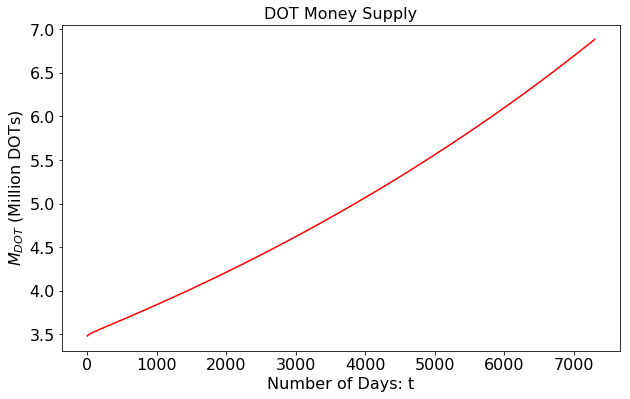

In [5]:
# Time array
t = np.linspace(0, T, T+1)
# Time Series of the DOT Money Supply
plt.figure(figsize=(10,6))
plt.plot(t, M_dot/10**6,"-r")
plt.title('DOT Money Supply',fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('$M_{DOT}$ (Million DOTs)', fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('DOT_MoneySupply.pdf')

### 1.4. Polkadot Real Income and DOT Price

In [6]:
P_dot, Y_dotReal, Inf_dot = dotPrice(T, c_dot, Y_dot, I_dot, r_dot, M_dot, N_P_dot)

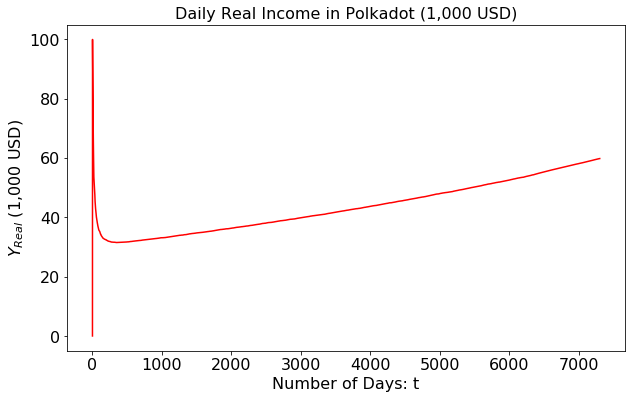

In [7]:
# Time Series of Real Income in Polkadot
plt.figure(figsize=(10,6))
plt.plot(t, np.multiply(P_dot,Y_dotReal)/10**(3),"-r")
plt.title('Daily Real Income in Polkadot (1,000 USD)',fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('$Y_{Real}$ (1,000 USD)', fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('DOT_RealIncome.pdf')

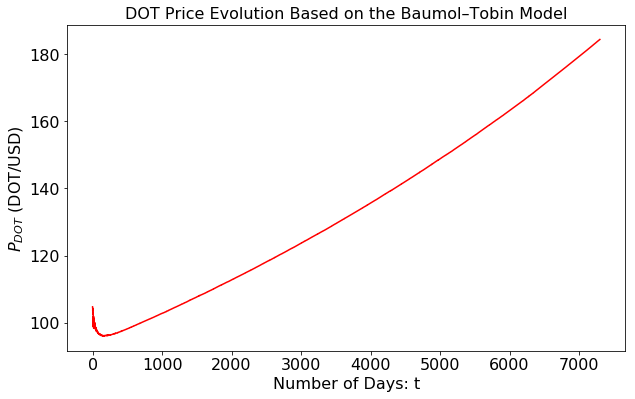

In [8]:
# Time Series of DOT Price in USD
plt.figure(figsize=(10,6))
plt.plot(t, P_dot,"-r")
plt.title('DOT Price Evolution Based on the Baumol–Tobin Model',fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('$P_{DOT}$ (DOT/USD)', fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('DOT_Price.pdf')

### 1.5. Parachain Slot Valuation

In [9]:
# Parachain Cost
def parachainCostDeposit(f_p, N_p, Inf_dot, Y_dotReal, P_dot):
    # Preallocate C_p, D_p and data matrices
    C_p = np.zeros(4)
    D_p = np.zeros(4)
    C_p_usd = np.zeros(4)
    D_p_usd = np.zeros(4)
    data = np.zeros((4,4))
    for i in range(0,4):
        # Calculate period
        tau = (i+1)*180
        # Parachain cost in real terms in DOTs
        C_p[i] = (f_p/N_p)*np.sum(Y_dotReal[0:tau])
        # Parachain cost in USD
        C_p_usd[i] = C_p[i]*P_dot[tau]
        # Parachain deposit in real terms in DOTs
        D_p[i] = np.multiply(C_p[i], 1/(Inf_dot[tau] - 1))
        # Parachain deposit in USD
        D_p_usd[i] = D_p[i]*P_dot[tau]
    # Table of parachain costs and deposits
    data[0,:] = C_p
    data[1,:] = C_p_usd
    data[2,:] = D_p
    data[3,:] = D_p_usd
    periods = ['6 Months','12 Months','18 Months','24 Months']
    df_names = ['Parachain Cost (DOT)','Parachain Cost (USD)','Parachain Deposit (DOT)','Parachain Deposit (USD)']
    df_p = pd.DataFrame(data, df_names, periods)
    return C_p, D_p, df_p

In [10]:
C_p, D_p, df_p = parachainCostDeposit(f_p, N_p, Inf_dot, Y_dotReal, P_dot)
display(df_p.round(1))

,6 Months,12 Months,18 Months,24 Months
Parachain Cost (DOT),452.5,808.6,1157.7,1506.1
Parachain Cost (USD),43504.4,78466.0,114073.5,150905.6
Parachain Deposit (DOT),20481.3,20391.2,20250.2,20095.9
Parachain Deposit (USD),1969324.8,1978786.7,1995307.5,2013591.4


## 2. Token Accounts

### 2.1. Add Accounts with the Same Number of Tokens

In [11]:
# addAccounts adds a number of accounts with the same balances
# -> Inputs: 
# N_add: Number of accounts to be added
# w_add_total: Balance of accounts in TKN
# <- Output:
# A vector of account balances
def addAccounts(N_add,w_add_total):
    w_add_0 = np.multiply(w_add_total/N_add, np.ones((N_add)))
    return w_add_0

### 2.2. Initial Wealth Distribution (TKN)

In [12]:
# Private Investors
w_private_0 = addAccounts(N_private,N_private_tkn)
# Crowdfunding ICO Participants
w_ico_0 = addAccounts(N_ico,N_ico_tkn)
# Founders & Employee
w_founders_0 = addAccounts(N_founders,N_founders_tkn) 
# Ecosystem Accounts
w_ecosystem_0 = addAccounts(N_ecosystem,N_ecosystem_tkn)
# Rewards Account
w_rewards_0 = addAccounts(N_rewards,N_rewards_tkn)
# Future Fundraising
w_future_fundraising_0 = addAccounts(N_future_fundraising,N_future_fundraising_tkn)
# Treasury TKN reserve 
w_treasury_tkn_0 = addAccounts(1,N_treasury_tkn)
# Treasury DOT reserve
N_treasury_dot = (N_private_tkn + N_ico_tkn)*P_tkn_0/P_dot[0]
w_treasury_dot_0 = addAccounts(1,N_treasury_dot)

### 2.3. Selecting Collators and  Initial Clients from the Initial Token Distribution

In [13]:
# Collators from the initial distribution
w_collators_0 = w_ico_0[0:N_collators]
# Clients from the initial distribution
w_clients_0 = w_ico_0[N_collators:N_collators+N_clients_0]
# Passive Accounts from the initial distribution
w_passive_0 = w_ico_0[N_collators+N_clients_0:N_ico]

## 3. Token Economics

### 3.1. Cobb-Douglas Utility Function

In [14]:
def cobbDouglas(a, b, N_clients, N_collators):
    Ucd = ((1+N_clients)**a)*((N_collators)**b)
    return Ucd

### 3.2. Service Price Utility Function

In [15]:
def priceUtility(alpha, serviceFee, P_tkn, t):
    if t==1:
        Up = 0
    else:
        Up = alpha*serviceFee*(P_tkn[t-2] - P_tkn[t-1])
    return Up

### 3.3. Token Price Model

In [16]:
def tokenPrice(T, c_tkn, revenues, P_tkn_0, M_tkn, r_opp, Normalization_tkn):
    # Define a unit vector of size T+1
    idT = np.ones((1,T+1))
    # Calculate real income (no inflation, hence equal to nominal)
    Y_tkn = revenues
    # Calculate money demand
    L_tkn = np.sqrt(0.5*c_tkn*np.multiply(Y_tkn,365/r_opp))
    # Calculate TKN price
    P_tkn = P_tkn_0*Normalization_tkn*np.multiply(M_tkn,1/L_tkn)
    return P_tkn

In [17]:
# Reset the simulation time
year = 10
T = 365*year

### 3.4. The Microeconomic Token Model 

In [18]:
def tokenEconomics(a, b, N_clients_0, N_collators, N_potential_clients,\
                   N_rewards, w_collators_0, w_clients_0, w_passive_0,\
                   w_treasury_tkn_0, w_treasury_dot_0, w_rewards_0,\
                   P_tkn_0, D_p, C_p, collatorFee, serviceFee,\
                   f_profit_collator, f_profit_treasury, f_rewards,\
                   beta, U_benchmark, N_tkn, c_tkn, r_opp):
    
    # Preallocate Variables
    # Number of Clients
    N_clients = np.zeros(T+1)
    # Convert N_clients into integers
    N_clients = N_clients.astype(int)
    # Collator Wealth
    w_collators = np.zeros((T+1,N_collators))
    # Client and passive wealth
    w_clients = np.zeros((T+1,N_potential_clients))
    # Treasury TKN account
    w_treasury_tkn = np.zeros((T+1,1))
    # Treasury DOT account
    w_treasury_dot = np.zeros((T+1,1))
    # Revenues, Costs and Profits
    revenues = np.zeros(T+1)
    costs = np.zeros(T+1)
    profits = np.zeros(T+1)
    # Token price
    P_tkn = np.zeros(T+1)
    
    # Private Investors
    # w_private = np.zeros((T+1,N_private)) # remains constant in this version
    # Founders & Employee
    #w_founders = np.zeros((T+1,N_founders)) # remains constant in this version
    # Ecosystem Accounts
    #w_ecosystem_0 = np.zeros((T+1,N_ecosystem)) # remains constant in this version
    # Rewards Account
    w_rewards = np.zeros((T+1,N_rewards))
    
    # Set initial values
    N_clients[0] = N_clients_0
    w_collators[0,:] = w_collators_0
    w_clients[0,0:N_clients_0] = w_clients_0
    w_clients[0,N_clients_0:N_potential_clients] = w_passive_0
    w_treasury_tkn[0] = w_treasury_tkn_0
    w_treasury_dot[0] = w_treasury_dot_0
    w_rewards[0] = w_rewards_0
    P_tkn[0] = P_tkn_0
    
    # Deposit DOTs to lease the parachain slot for 24 months
    w_treasury_dot[0] = w_treasury_dot[0] - D_p[3]
    
    # Update values of these matrices in time
    t = 1
    while t <= T:
        # Calculate revenues
        revenues[t] = np.multiply(N_clients[t-1], serviceFee)
        # Calculate costs
        costs[t] = np.multiply(N_clients[t-1], collatorFee)
        # Calculate profits
        profits[t] = revenues[t] - costs[t]
        
        # Update client accounts
        # Active clients
        w_clients[t,0:N_clients[t-1]] = w_clients[t-1,0:N_clients[t-1]] - serviceFee
        # Passive accounts
        w_clients[t,N_clients[t-1]:N_potential_clients] = w_clients[t-1,N_clients[t-1]:N_potential_clients]
        # Pay collator fees
        w_collators[t,:] = w_collators[t-1,:] + costs[t]/N_collators
        
        # Update treasury DOT reserve when the next deposit time comes
        if np.mod(t,(180*4)) == 0:
            # Substract the parachain slot cost at the end of lease periods
            w_treasury_dot[t] = w_treasury_dot[t-1] - C_p[3]
        else:
            w_treasury_dot[t] = w_treasury_dot[t-1]
        
        # Distribute collator share of profits 
        w_collators[t,:] = w_collators[t,:] + f_profit_collator*profits[t]/N_collators
        # Update treasury TKN reserve
        w_treasury_tkn[t] = w_treasury_tkn[t-1] + f_profit_treasury*profits[t]
        
        # Incentivize collators with rewards
        if w_rewards[t-1] > 0:
            w_collators[t,:] = w_collators[t,:] + f_rewards*w_rewards_0/T
            # Update rewards account
            w_rewards[t] = w_rewards[t-1] - N_collators*f_rewards*w_rewards[t-1]/T
        
        # Update the number of clients using the dynamic demand model
        # Positive client utility from increasing demand
        Ucb = cobbDouglas(a, b, N_clients[t-1], N_collators)
        # Negative (positive) client utility from increasing (decreasing) token price
        Up = priceUtility(alpha, serviceFee, P_tkn, t)
        # Total client utility
        U = Ucb + Up
        
        # Update number of clients
        N_clients[t] = round(N_clients[t-1] + beta*(U - U_benchmark))
        if N_clients[t] > N_potential_clients:
            N_clients[t] = N_potential_clients
        N_clients = N_clients.astype(int)
        
        # Calculate new token price based on the real demand
        # Money supply
        M_tkn = np.sum(w_collators[t,:]) + np.sum(w_clients[t,0:N_clients[t-1]])
        # Calculate money demand at period 1
        L_tkn_1 = np.sqrt(0.5*c_tkn*np.multiply(revenues[1],365/r_opp))
        # Calculate TKN price normalization to match the initial token price
        Normalization_tkn = 1/(np.multiply(N_tkn,1/L_tkn_1))
        # Token price at time t
        P_tkn[t] = tokenPrice(T, c_tkn, revenues[t], P_tkn_0, M_tkn, r_opp, Normalization_tkn)
        
        # Switch to the next time step
        t = t + 1
    return revenues, costs, profits, w_clients, w_collators, w_treasury_dot, w_treasury_tkn, w_rewards, N_clients, P_tkn

In [19]:
revenues, costs, profits, w_clients, w_collators, w_treasury_dot, w_treasury_tkn, w_rewards, N_clients, P_tkn =\
tokenEconomics(a, b, N_clients_0, N_collators, N_potential_clients,\
                   N_rewards, w_collators_0, w_clients_0, w_passive_0,\
                   w_treasury_tkn_0, w_treasury_dot_0, w_rewards_0,\
                   P_tkn_0, D_p, C_p, collatorFee, serviceFee,\
                   f_profit_collator, f_profit_treasury, f_rewards,\
                   beta, U_benchmark, N_tkn, c_tkn, r_opp)
t = np.linspace(0, T, T+1)

### 3.5. Calculate Wealth Distribution

In [20]:
# The below accounts are assumed to remain passive
w_private = np.ones((T+1,w_private_0.shape[0]))*w_private_0[0]
w_founders = np.ones((T+1,w_founders_0.shape[0]))*w_founders_0[0]
w_ecosystem = np.ones((T+1,w_ecosystem_0.shape[0]))*w_ecosystem_0[0]
w_future_fundraising = np.ones((T+1,1))*w_future_fundraising_0
# The overall wealth excluding client accounts
w = np.sort(np.concatenate((w_collators,w_treasury_tkn,w_rewards,\
                            w_private,w_founders,w_ecosystem,w_future_fundraising),axis=1))

### 3.6. Gini Coefficient of Wealth Inequality

In [21]:
# Calculate the time series of the Gini coffecient in order to 
# observe the evolution of the inequality of wealth among nominators
# ->Input parameter:
# wealth: t x n time series of matrix of the wealth of nominators 
# <-Output: 
# G: The time series of the Gini coefficient
def Gini(wealth):
    # Calculate the number of time periods
    N_t = wealth.shape[0]
    # Calculate the number of nominators and validators
    N = wealth.shape[1]
    # Preallocate the Gini coefficient time series vector
    G = np.zeros((N_t,1))
    # Calculate Gini coefficient for each time t
    for i in range(0,wealth.shape[0]):
        # Order wealth in ascending order
        wealth[i,:] = np.sort(wealth[i,:])
        # Calculate the rank
        rank = np.arange(1,wealth[i,:].shape[0]+1)
        G[i] = (np.sum((2*rank - N - 1)*wealth[i,:]))/(N*np.sum(wealth[i,:]))
    return G

In [22]:
# Calculate the time series of the Gini Coefficient
G = Gini(w)

### 3.7. Summary Plots

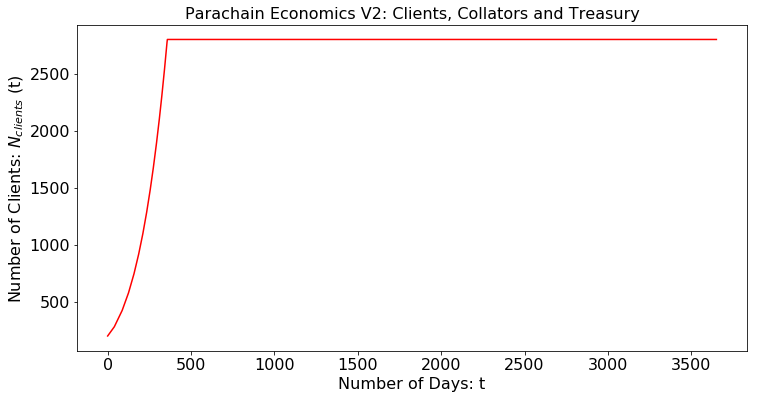

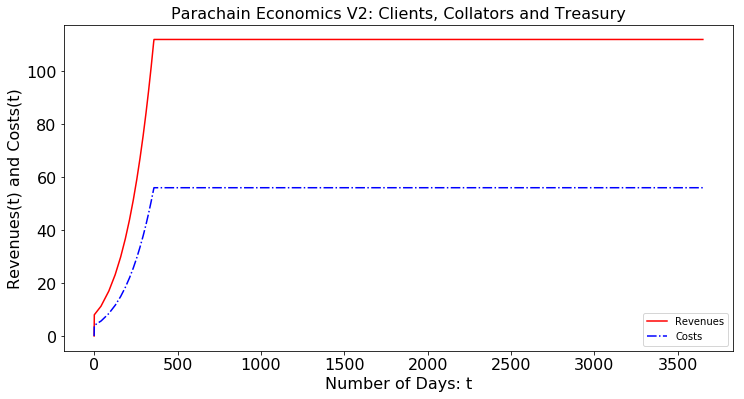

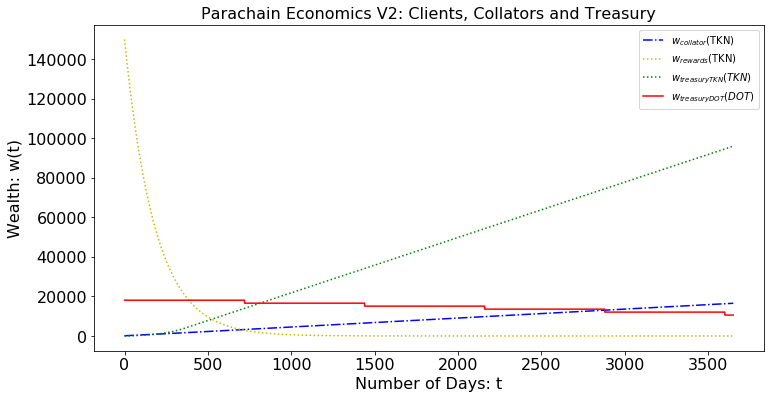

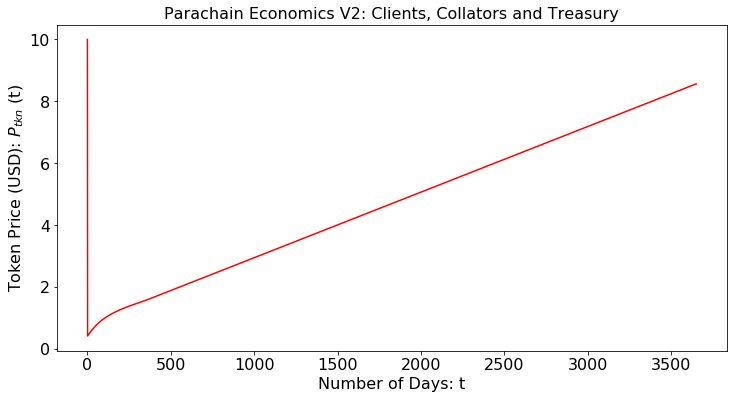

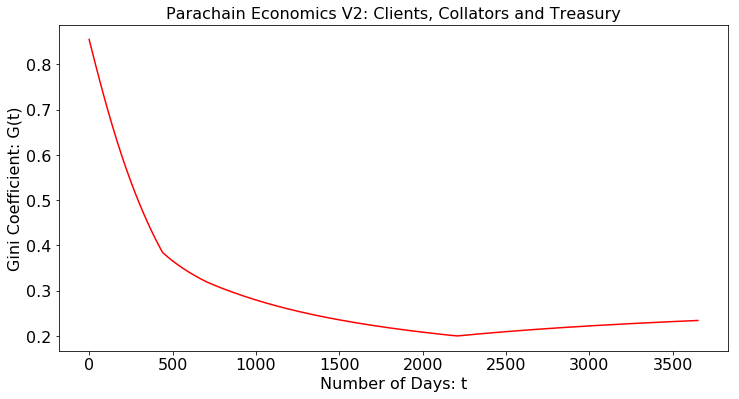

In [24]:
# Summary Plots
version_title = 'Parachain Economics V2: Clients, Collators and Treasury'
# Number of Clients
plt.figure(figsize=(12,6))
plt.plot(t, N_clients,"-r",linestyle='-', label = "Title")
plt.title(version_title,fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Number of Clients: $N_{clients}$ (t)',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('NumberOfClients.pdf')

# Revenues and Costs
plt.figure(figsize=(12,6))
plt.plot(t, revenues,"-r",linestyle='-', label = "Revenues")
plt.plot(t, costs,"-b",linestyle='-.', label = "Costs")
plt.title(version_title,fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Revenues(t) and Costs(t)',fontsize=16)
plt.legend(loc="best",fontsize=10)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('RevenuesCosts.pdf')

# Wealth
plt.figure(figsize=(12,6))
plt.plot(t, w_collators[:,0],"-b",linestyle='-.', label = "$w_{collator}$(TKN)")
plt.plot(t, w_rewards,"-y",linestyle=':', label="$w_{rewards}$(TKN)")
plt.plot(t, w_treasury_tkn,"-g",linestyle=':', label="$w_{treasuryTKN}(TKN)$")
plt.plot(t, w_treasury_dot,"-r",linestyle='-', label="$w_{treasuryDOT}(DOT)$")
plt.title(version_title,fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Wealth: w(t)',fontsize=16)
plt.legend(loc="best",fontsize=10)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('Wealth.pdf')

# Token Price
plt.figure(figsize=(12,6))
plt.plot(t, P_tkn,"-r",linestyle='-', label = "Title")
plt.title(version_title,fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Token Price (USD): $P_{tkn}$ (t)',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('TokenPrice.pdf')

# Gini coefficient 
plt.figure(figsize=(12,6))
plt.plot(t, G,"-r",linestyle='-', label = "Title")
plt.title(version_title,fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Gini Coefficient: G(t)',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('GiniCoefficient.pdf')